In [ ]:
# default_exp viz

# viz

> Visualization routines

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
# Do this on Colab and then restart runtime:
#!pip install fastai --upgrade | grep -v 'already satisfied'
#!pip install git+https://github.com/drscotthawley/mrspuff.git --upgrade | grep -v 'already satisfied'

In [ ]:
#export
import matplotlib.pyplot as plt 
import numpy as np 
from numpy import linalg as LA
from fastcore.basics import *
from fastai.callback.core import Callback 
from fastai.callback.progress import ProgressCallback
from mrspuff.utils import calc_prob, on_colab
from mrspuff.scrape import exhibit_urls
import plotly.graph_objects as go
from bokeh.plotting import figure, ColumnDataSource, output_file, show
from bokeh.io import output_notebook
from bokeh.models import Label
from IPython.display import display, HTML

In [ ]:
#export 
class TrianglePlot2D_MPL():
    "Plot categority predictions for 3 categories - matplotlib style"
    """ pred: (n,3): probability values of n data points in each of 3 classes
        targ: (n):   target value (0,1,2) for each data point"""
    def __init__(self, pred, targ=None, labels=['0','1','2'], show_labels=True, show_bounds=True, comment=''):
        store_attr()
        self.fig = plt.figure(figsize=(5,4))
        self.ax = self.fig.add_subplot(111)
        if show_labels:
            self.ax.text(-1,0, labels[0], ha='right', va='top', size=14)
            self.ax.text(1,0, labels[1], size=14, va='top')
            self.ax.text(0,1, labels[2], va='bottom', ha='center', size=14)
        if comment != '':
            self.ax.text(-1.1,1, comment, va='bottom', ha='left', size=14)
        if show_bounds: # draw lines for decision boundaries, and 'ideal' points
            self.ax.plot([0,0],[0.333,0], color='black')
            self.ax.plot([0,.5],[0.333,.5], color='black')
            self.ax.plot([0,-.5],[0.333,.5], color='black')
            self.ax.plot(-1,0, marker='o', color='black')
            self.ax.plot(1,0, marker='o', color='black')
            self.ax.plot(0,1, marker='o', color='black') 
        eps = 0.02
        self.ax.set_xlim(-1-eps,1+eps)
        self.ax.set_ylim(-eps,1+eps)
        self.ax.set_axis_off()
    def do_plot(self):
        colors = self.pred if (self.targ is None) else [ ['red','green','blue'][i] for i in self.targ]
        self.scat = self.ax.scatter(self.pred.T[1]-self.pred.T[0],self.pred.T[2], facecolors=colors, marker='o')
        plt.tight_layout()
        return plt
    def update(self, pred, targ):
        self.pred, self.targ = pred, targ 
        return self.do_plot()

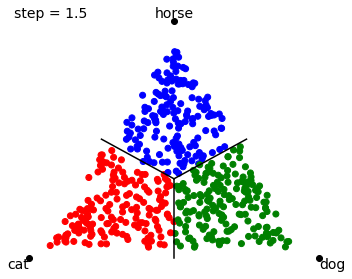

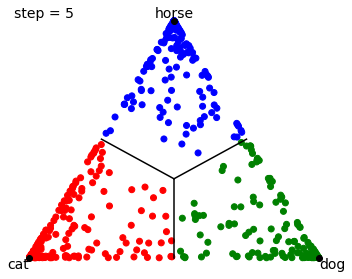

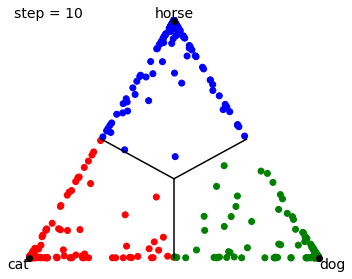

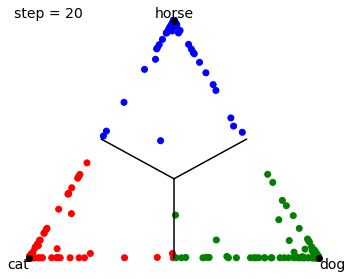

In [ ]:
labels = ['cat','dog','horse']
for s in [1.5,5,10,20]:
    prob, targ = calc_prob(500, s=s)
    myplot = TrianglePlot2D_MPL(prob, targ=targ, labels=labels, show_bounds=True, comment=f'step = {s}').do_plot()

In [ ]:
#export 

# cat-dog-horse sample image urls (Warning: these may change & stop working; perhaps switch to Imgur)
CDH_SAMPLE_URLS = ['https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/Felis_silvestris_catus_lying_on_rice_straw.jpg/220px-Felis_silvestris_catus_lying_on_rice_straw.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/e/e3/Perfect_Side_View_Of_Black_Labrador_North_East_England.JPG',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/SilverMorgan.jpg/250px-SilverMorgan.jpg']

bokeh_already_setup = False
def setup_bokeh():
    """bokeh requires we add jquery manually """
    global bokeh_already_setup
    if not bokeh_already_setup:
        js = '<script src="//ajax.googleapis.com/ajax/libs/jquery/1.9.1/jquery.min.js"></script>'
        display(HTML(js))
        bokeh_already_setup = True


class TrianglePlot2D_Bokeh():
    """This gives a 2d plot with image tooltips when the mouse hovers over a data point."""
    # NOTE: in Markdown cells before trying to show the plot, you may need to 
    # force your own JQery import in order for the graph to appear (i.e. if you 
    # get "Uncaught ReferenceError: $ is not defined").  If so, add this:
    # <script src="//ajax.googleapis.com/ajax/libs/jquery/1.9.1/jquery.min.js"></script>

    def __init__(self, 
            pred=None,                  # (n,3): probability values of n data points in each of 3 classes
            targ=None,                  # (n):   target value (0,1,2) for each data point
            labels:list=['0','1','2'],  # the class labels
            show_bounds:bool=False,     # show inter-class boundaries or not
            show_labels:bool=True,      # point to class ideal poles with arrows & labels
            show_axes:bool=True,        # show axes or not
            urls:list=None,              # image urls to display upon mouseover (default: stock images)
            comment:str=''              # just a comment to put in the top left corner
            ) -> None:                  # __init__ isn't allowed to return anything (it's a Python thing)
        store_attr()
        output_notebook(hide_banner=True)   # output_file("toolbar.html")
        self.colors =  ['red','green','blue']
        self.TOOLTIPS_HTML = """
            <div>
                <div>
                    <img
                        src="@imgs" height="50" alt="@imgs" 
                        style="float: left; margin: 0px 15px 15px 0px;"
                        border="2"
                    ></img>
                </div>
                <div>
                    <span style="font-size: 17px; font-weight: bold;">@desc</span>
                    <span style="font-size: 15px; color: #966;">[$index]</span>
                </div>
                <!---commenting-out coordinate values <div>
                    <span style="font-size: 10px; color: #696;">($x, $y)</span>
                </div> -->
            </div>
        """
        #assert self.targ is not None, 'TODO: right now we require targ' 
        setup_bokeh()
        self.clear()
        return 

    def clear(self):
        self.p = figure(plot_width=400, plot_height=350, tooltips=self.TOOLTIPS_HTML, title="Mouse over the dots") 

    def do_plot(self, pred=None, targ=None, urls:list=None):
        self.pred = self.pred if pred is None else pred
        self.targ = self.targ if targ is None else targ 
        self.urls = self.urls if urls is None else urls
        assert self.pred is not None 
        
        xs, ys = self.pred.T[1] - self.pred.T[0], self.pred.T[2]

        if self.show_bounds: 
            self.p.line([0, 0],[0.333,0], line_width=2, color='black')
            self.p.line([0,.5],[0.333,.5], line_width=2, color='black')
            self.p.line([0,-.5],[0.333,.5], line_width=2, color='black')

        n = self.pred.shape[0]
        full_labels = [self.labels[self.targ[i]] for i in range(n)]
        full_colors = [self.colors[self.targ[i]] for i in range(n)]
        full_urls = self.urls if self.urls is not None else [CDH_SAMPLE_URLS[self.targ[i]] for i in range(n)]
        source = ColumnDataSource( data=dict(x=xs, y=ys, desc=full_labels, imgs=full_urls, colors=full_colors ) )
        self.p.circle('x', 'y', size=6, line_color='colors', fill_color='colors', source=source)

        if self.show_labels:
            self.p.add_layout( Label(x=-1, y=0, text=self.labels[0], text_align='right'))
            self.p.add_layout( Label(x=1, y=0, text=self.labels[1]))
            self.p.add_layout( Label(x=0, y=1, text=self.labels[2], text_align='center'))
        
        if self.comment != '':
            self.p.add_layout( Label(x=-1, y=0.95, text=self.comment, text_align='left'))

        return show(self.p)

    def update(self, pred, targ):
        self.pred, self.targ = pred, targ 
        self.clear()
        return self.do_plot()

In [ ]:
prob, targ = calc_prob(n=400)
plot = TrianglePlot3D_Plotly(prob, targ=targ, labels=labels, show_bounds=True, margin_t=0)
plot.do_plot()

In [ ]:
TrianglePlot3D_Plotly(prob, margin_t=0).do_plot()

In [ ]:
#export 

# cat-dog-horse sample image urls (Warning: these may change & stop working; perhaps switch to Imgur)
CDH_SAMPLE_URLS = ['https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/Felis_silvestris_catus_lying_on_rice_straw.jpg/220px-Felis_silvestris_catus_lying_on_rice_straw.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/e/e3/Perfect_Side_View_Of_Black_Labrador_North_East_England.JPG',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/SilverMorgan.jpg/250px-SilverMorgan.jpg']

bokeh_already_setup = False
def setup_bokeh():
    """bokeh requires we add jquery manually """
    global bokeh_already_setup
    if not bokeh_already_setup:
        js = '<script src="//ajax.googleapis.com/ajax/libs/jquery/1.9.1/jquery.min.js"></script>'
        display(HTML(js))
        bokeh_already_setup = True


class TrianglePlot2D_Bokeh():
    """This gives a 2d plot with image tooltips when the mouse hovers over a data point."""
    # NOTE: in Markdown cells before trying to show the plot, you may need to 
    # force your own JQery import in order for the graph to appear (i.e. if you 
    # get "Uncaught ReferenceError: $ is not defined").  If so, add this:
    # <script src="//ajax.googleapis.com/ajax/libs/jquery/1.9.1/jquery.min.js"></script>

    def __init__(self, 
            pred=None,                  # (n,3): probability values of n data points in each of 3 classes
            targ=None,                  # (n):   target value (0,1,2) for each data point
            labels:list=['0','1','2'],  # the class labels
            show_bounds:bool=False,     # show inter-class boundaries or not
            show_labels:bool=True,      # point to class ideal poles with arrows & labels
            show_axes:bool=True,        # show axes or not
            urls:list=None,              # image urls to display upon mouseover (default: stock images)
            comment:str=''              # just a comment to put in the top left corner
            ) -> None:                  # __init__ isn't allowed to return anything (it's a Python thing)
        store_attr()
        output_notebook(hide_banner=True)   # output_file("toolbar.html")
        self.colors =  ['red','green','blue']
        self.TOOLTIPS_HTML = """
            <div>
                <div>
                    <img
                        src="@imgs" height="50" alt="@imgs" 
                        style="float: left; margin: 0px 15px 15px 0px;"
                        border="2"
                    ></img>
                </div>
                <div>
                    <span style="font-size: 17px; font-weight: bold;">@desc</span>
                    <span style="font-size: 15px; color: #966;">[$index]</span>
                </div>
                <!---commenting-out coordinate values <div>
                    <span style="font-size: 10px; color: #696;">($x, $y)</span>
                </div> -->
            </div>
        """
        assert self.targ is not None, 'TODO: right now we require targ' 
        setup_bokeh()
        self.clear()
        return 

    def clear(self):
        self.p = figure(plot_width=400, plot_height=350, tooltips=self.TOOLTIPS_HTML, title="Mouse over the dots") 

    def do_plot(self, pred=None, targ=None):
        self.pred = self.pred if pred is None else pred
        self.targ = self.targ if targ is None else targ 

        assert self.pred is not None 
        
        xs, ys = self.pred.T[1] - self.pred.T[0], self.pred.T[2]

        if self.show_bounds: 
            self.p.line([0, 0],[0.333,0], line_width=2, color='black')
            self.p.line([0,.5],[0.333,.5], line_width=2, color='black')
            self.p.line([0,-.5],[0.333,.5], line_width=2, color='black')

        n = self.pred.shape[0]
        full_labels = [self.labels[self.targ[i]] for i in range(n)]
        full_colors = [self.colors[self.targ[i]] for i in range(n)]
        full_urls = self.urls if self.urls is not None else [CDH_SAMPLE_URLS[self.targ[i]] for i in range(n)]
        source = ColumnDataSource( data=dict(x=xs, y=ys, desc=full_labels, imgs=full_urls, colors=full_colors ) )
        self.p.circle('x', 'y', size=6, line_color='colors', fill_color='colors', source=source)

        if self.show_labels:
            self.p.add_layout( Label(x=-1, y=0, text=self.labels[0], text_align='right'))
            self.p.add_layout( Label(x=1, y=0, text=self.labels[1]))
            self.p.add_layout( Label(x=0, y=1, text=self.labels[2], text_align='center'))
        
        if self.comment != '':
            self.p.add_layout( Label(x=-1, y=0.95, text=self.comment, text_align='left'))

        return show(self.p)

    def update(self, pred, targ):
        self.pred, self.targ = pred, targ 
        self.clear()
        return self.do_plot()

In [ ]:
urls = exhibit_urls(targ, labels)
bokplot = TrianglePlot2D_Bokeh(prob, targ=targ, labels=labels, show_bounds=True, comment='2D Bokeh', urls=urls)
bokplot.do_plot()

In [ ]:
#export 
class VizPreds(Callback):
    "This fastai callback is designed to call the bokeh triangle plot with each batch of training, using validation data."
    order = ProgressCallback.order+1
    def __init__(self, 
        method=TrianglePlot2D_Bokeh   # callback to plotting method; must have ".do_plot(preds,targs)" 
    ): self.method = method
    def before_fit(self, **kwargs): self.plot = self.method(labels=self.dls.vocab)
    def after_batch(self, **kwargs):
        if not self.learn.training:
            with torch.no_grad(): 
                preds, targs = F.softmax(self.learn.pred, dim=1), self.learn.y
                preds, targs = [x.detach().cpu().numpy().copy() for x in [preds,targs]]
                self.plot.do_plot(preds, targs)

In [ ]:
#export 
def image_and_bars(values, labels, image_url, title="Probabilities", height=225, width=500):
    """Plot an image along with a bar graph"""
    fig = go.Figure()
    fig.add_trace( go.Bar(x=labels, y=values, marker_color=["red","green","blue"]) )
    fig.add_layout_image(
        dict(
            source=image_url,
            xref="paper", yref="paper",
            x=-0.2, y=0.5,
            sizex=1, sizey=1,
            xanchor="right", yanchor="middle"
        )
    )
        # update layout properties
    fig.update_layout(
        autosize=False,
        height=height, width=width,
        bargap=0.15,
        bargroupgap=0.1,
        barmode="stack",
        hovermode="x",
        margin=dict(r=20, l=width*0.55, t=30, b=20),
        yaxis=dict(range=[0,1]),
        title={
        'text': title,
        'y':0.9,
        'x':0.76,
        'xanchor': 'center',
        'yanchor': 'bottom'}
    )
    return fig 

In [ ]:
data = np.array([[0.7,0.2,0.1],[0.15,0.6,0.25],[0.05,0.15,0.8]])
for i in range(3):
    image_and_bars(data[i], labels, CDH_SAMPLE_URLS[i]).show(config = {'displayModeBar': False})
    print("")

In [ ]:
#export 

def sorted_eig(A):  # returns sorted eigenvalues (& their corresponding eignevectors) of A
    lambdas, vecs = LA.eig(A)
    # Next line just sorts values & vectors together in order of decreasing eigenvalues
    lambdas, vecs = zip(*sorted(zip(list(lambdas), list(vecs.T)),key=lambda x: x[0], reverse=True))
    return lambdas, np.array(vecs).T  # un-doing the list-casting from the previous line

def pca_proj(data, dim=3):
    """Projects data using Principal Component Analysis"""

    cov = np.cov(data.T)   # get covariance matrix
    lambdas, vecs = sorted_eig(np.array(cov))  # get the eigenvectors
    W = vecs[:,0:dim]                      # Grab the 2 most significant dimensions
    return np.array(data @ W, dtype=np.float32)  # Last step of PCA: projection 

In [ ]:
prob4, targ4 = calc_prob(n=500, dim=4)  # 4d probabilities
prob4, targ4 = np.vstack((np.eye(4),prob4)), np.hstack((np.arange(4),targ4)) # tack on poles b4 pca
prob3 = pca_proj(prob4)                 # use PCA for coordinate transformation to 3D hyperplane
TrianglePlot3D_Plotly(prob3, targ=targ4, labels=labels+['bird'], show_labels=True, \
    show_axes=False, poles_included=True).do_plot()